In [5]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [6]:
from importlib import reload
reload(data_prepro)
reload(model_train)
reload(model_fcast)

<module 'model_fcast' from 'C:\\2023_11-PTSFC\\model_fcast.py'>

### Params

In [7]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# # get current date and set time to 00:00
# t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)

# = = = = = = = = = = = = = 
# = = = = = = = = = = = = = 
# !!! enter desired week / date of evaluation here !!!
custom_date = '2024-01-17'
t_now = pd.Timestamp(custom_date).replace(hour=0, minute=0, second=0, microsecond=0)
# = = = = = = = = = = = = = 
# = = = = = = = = = = = = = 

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)).tz_localize('CET'))
print(subm_timestamps)

wed = 2024-01-17 00:00:00
thu = 2024-01-18 00:00:00
[Timestamp('2024-01-19 12:00:00+0100', tz='CET'), Timestamp('2024-01-19 16:00:00+0100', tz='CET'), Timestamp('2024-01-19 20:00:00+0100', tz='CET'), Timestamp('2024-01-20 12:00:00+0100', tz='CET'), Timestamp('2024-01-20 16:00:00+0100', tz='CET'), Timestamp('2024-01-20 20:00:00+0100', tz='CET')]


### Data Prep

In [8]:
# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # take smaller dataset
# start   = '2018-01-01'
# end     = df_energy['timestamp_CET'].max()
# df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
#                                 (df_energy['timestamp_CET'] <= end)]

# print('- '*15)
# print(f"take smaller dataset ... from {start} to {end}")
# print(df_energy_small.info())

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # feature engineering and preparing training data

# df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
# df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

# X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_fturs = df_energy_fturs['gesamt']

# X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_dummy = df_energy_dummy['gesamt']

> cwd = C:\2023_11-PTSFC


> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


> 0 NA in df
> last valid index = 2024-01-17 22:45:00+00:00
> done and saved to 2015-01-01_2024-01-17_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79296 entries, 2014-12-31 23:00:00+00:00 to 2024-01-17 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79296 non-null  datetime64[ns, CET]
 1   gesamt         79296 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-17 18:00:00+00:00,2024-01-17 19:00:00+01:00,68915.50
2024-01-17 19:00:00+00:00,2024-01-17 20:00:00+01:00,64683.25
2024-01-17 20:00:00+00:00,2024-01-17 21:00:00+01:00,61607.25
2024-01-17 21:00:00+00:00,2024-01-17 22:00:00+01:00,59015.75
2024-01-17 22:00:00+00:00,2024-01-17 23:00:00+01:00,55470.00


### Model Train

In [9]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models 

# # quantile regression with dummies
# all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)

# # gradient boosting with features
# all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
#     pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
#     pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# read trained models

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# get all files in directory that end with .pickle
all_files = [file for file in os.listdir(path) if file.endswith('.pickle')]

quant_reg_files = [file for file in all_files if 'quant_reg' in file]
grad_boost_files = [file for file in all_files if 'grad_boost' in file]

print(f"quant reg files: {quant_reg_files}")
print(f"grad boost files: {grad_boost_files}")

with open(f'{path}/{quant_reg_files[0]}', 'rb') as handle:
    all_models_quant_reg = pickle.load(handle)

with open(f'{path}/{grad_boost_files[0]}', 'rb') as handle:
    all_models_grad_boost = pickle.load(handle)

quant reg files: ['20180101_20240117_all_models_quant_reg.pickle']
grad boost files: ['20180101_20240117_all_models_grad_boost.pickle']


### Iterative Ensemble Forecast from Thursday

first input dataframe from 2024-01-10 22:00:00+00:00 to 2024-01-17 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-21 11:00:00+00:00 to 2024-01-21 22:00:00+00:00
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


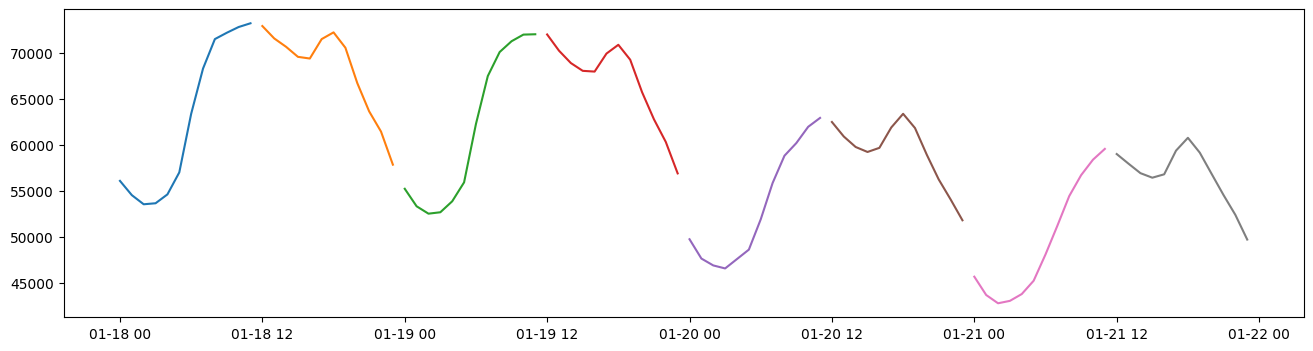

,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-17 23:00:00+00:00,49676.487563,53839.008122,56105.308456,57914.721736,60420.072952
2024-01-18 00:00:00+00:00,47568.961012,51965.976761,54554.025985,55991.598659,58277.964036
2024-01-18 01:00:00+00:00,46546.096652,51460.564915,53560.596420,54949.980577,57474.321299
2024-01-18 02:00:00+00:00,46809.177021,51587.241093,53670.534726,54966.502153,57304.393076
2024-01-18 03:00:00+00:00,48166.544307,52568.957375,54633.912597,56044.014907,57658.280763
...,...,...,...,...,...
2024-01-21 18:00:00+00:00,52708.712436,57712.491263,59173.412359,61678.766489,64723.176381
2024-01-21 19:00:00+00:00,50192.572863,54699.459525,56860.882786,59103.821785,61366.755391
2024-01-21 20:00:00+00:00,47342.203184,53169.860317,54568.069790,56719.826120,58562.890962
2024-01-21 21:00:00+00:00,45452.819185,50548.846977,52408.266613,54981.406312,58361.482631


In [10]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(f"first input dataframe from {start} to {end}")

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()
iterations = 8
# fig, axes = plt.subplots(1, iterations, figsize=(iterations*8,4))
# axes = axes.flatten()
fig, ax = plt.subplots(1, 1, figsize=(16,4))

print('- '*15) 
print(f"> to be forecasted")
for fcast_iter in range(iterations):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}", end='\r')

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    # plt.figure(figsize=(8,2))
    # ax = axes[fcast_iter]
    ax.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print('')
print('= '*15)
print(f"all iterative fcasts done ...")

plt.show()
display(df_fcast_iter_all)

#### Fix QC & Save to csv

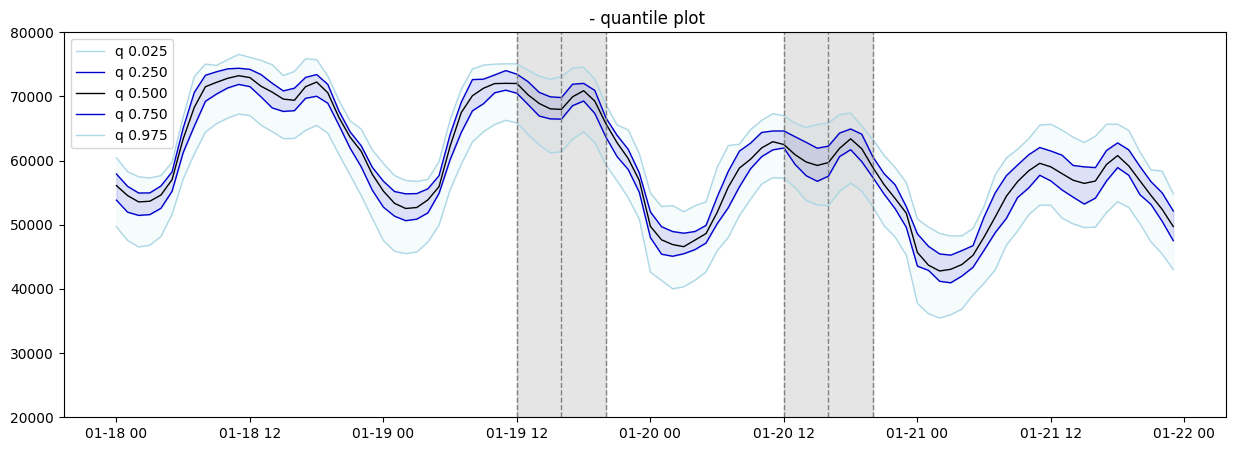

In [11]:
# - - - - - - - - - - - - - 
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed['timestamp_CET'] = df_iter_fcast_all_fixed.index.tz_convert('CET')
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps)

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_iter_fcast_all_fixed['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_iter_fcast_all_fixed.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

# # save entire iterative fcast to csv
# df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

# # save submission fcast to csv
# df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
# display(df_sub)

### Direct h-step Quant Reg Fcast

In [12]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

print('- '*15) 
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps 
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp['timestamp_CET'] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(df_temp, hour_method='seasonal', holiday_method='separate')
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop('timestamp_CET', axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-17 23:00:00+00:00 to 2024-01-21 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

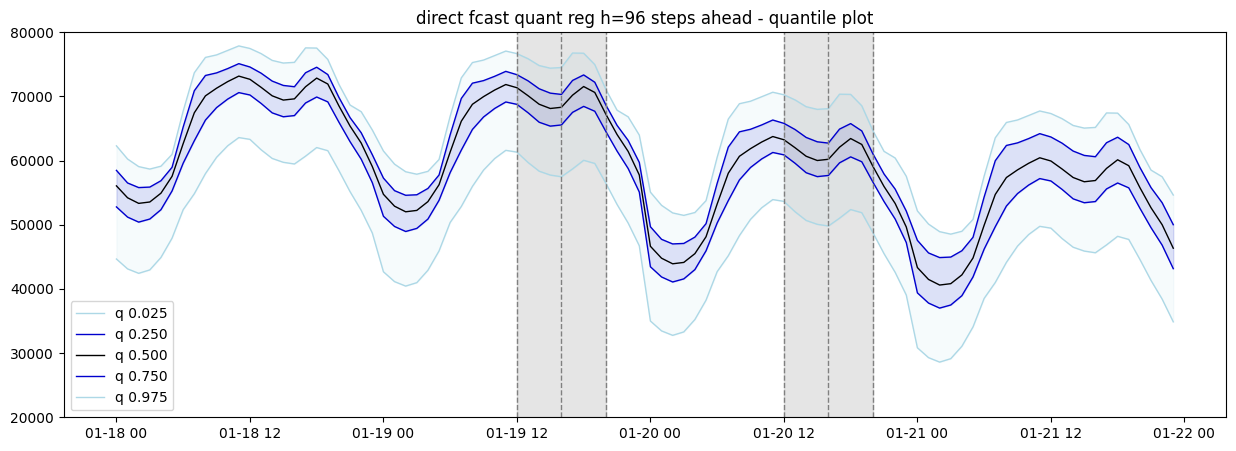

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-17,energy,36 hour,61.60175,69.138250,71.857500,73.90925,77.071750
1,2024-01-17,energy,40 hour,57.74625,65.374000,68.121500,70.51625,74.403821
2,2024-01-17,energy,44 hour,59.55775,67.691542,70.622750,72.21275,74.962429
3,2024-01-17,energy,60 hour,53.92625,61.269521,63.752625,66.32600,70.657179
4,2024-01-17,energy,64 hour,50.07075,57.505271,60.016625,62.93300,67.989250
5,2024-01-17,energy,68 hour,51.88225,59.822812,62.517875,64.62950,68.547857


In [13]:
# - - - - - - - - - - - - - 
# add CET col
df_quant_reg_direct_fcast['timestamp_CET'] = df_quant_reg_direct_fcast.index.tz_convert('CET')
# reorder cols
df_quant_reg_direct_fcast = df_quant_reg_direct_fcast[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_quant_reg_direct_fcast, subm_timestamps, title='direct fcast quant reg h=96 steps ahead')

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

display(df_sub)

### Naive Benchmark

In [14]:
print(df_energy.info())
df_energy.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79296 entries, 2014-12-31 23:00:00+00:00 to 2024-01-17 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79296 non-null  datetime64[ns, CET]
 1   gesamt         79296 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-17 18:00:00+00:00,2024-01-17 19:00:00+01:00,68915.50
2024-01-17 19:00:00+00:00,2024-01-17 20:00:00+01:00,64683.25
2024-01-17 20:00:00+00:00,2024-01-17 21:00:00+01:00,61607.25
2024-01-17 21:00:00+00:00,2024-01-17 22:00:00+01:00,59015.75
2024-01-17 22:00:00+00:00,2024-01-17 23:00:00+01:00,55470.00


In [15]:
# - - - - - - - - - - - - - 
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - - 
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark['timestamp_CET'].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark['timestamp_CET'].dt.weekday # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = df_energy_benchmark['timestamp_CET'].dt.isocalendar().week

last_t = 100
methods = ['linear', 'median_unbiased', 'normal_unbiased', 'weibull']

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods),len(fcast_timestamps),5))

for i,d in enumerate(fcast_timestamps):
        
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week
    
    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2)) 
    
    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['month'].between(d.month-1, d.month+1))

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0] 

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i,:] = np.quantile(match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method)

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):

    print('- '*15)
    print(f"method = {method}")
    print('- '*15)
    
    df_benchmark = pd.DataFrame(index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles])
    df_benchmark.loc[:,:] = pred_baseline[m_idx,:,:]
    # - - - - - - - - - - - - - 
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - - 
    # add CET col
    df_benchmark['timestamp_CET'] = df_benchmark.index.tz_convert('CET')
    # reorder cols
    df_benchmark = df_benchmark[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
    # - - - - - - - - - - - - - 
    # display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 78.25
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


#### Plot Naive Benchmark

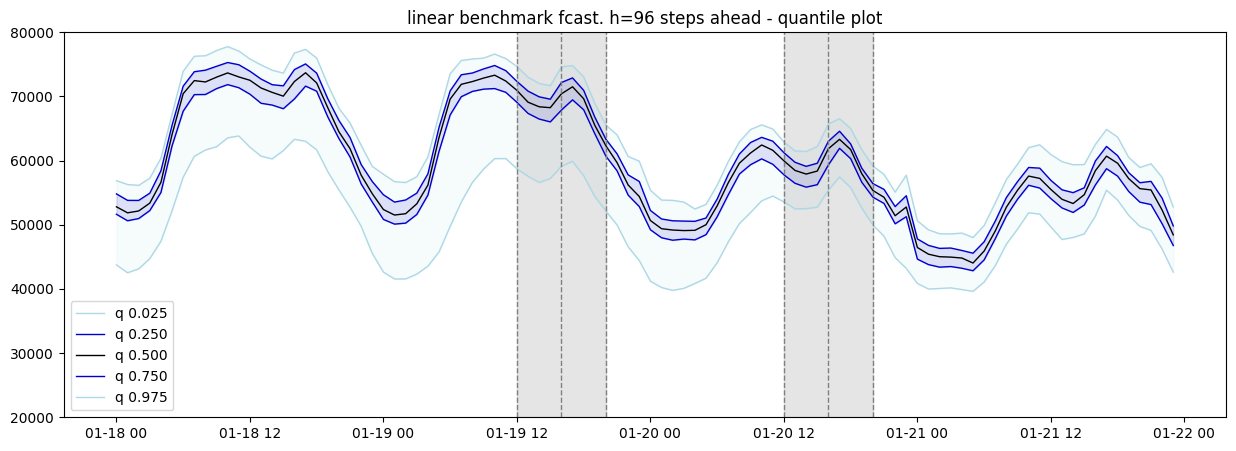

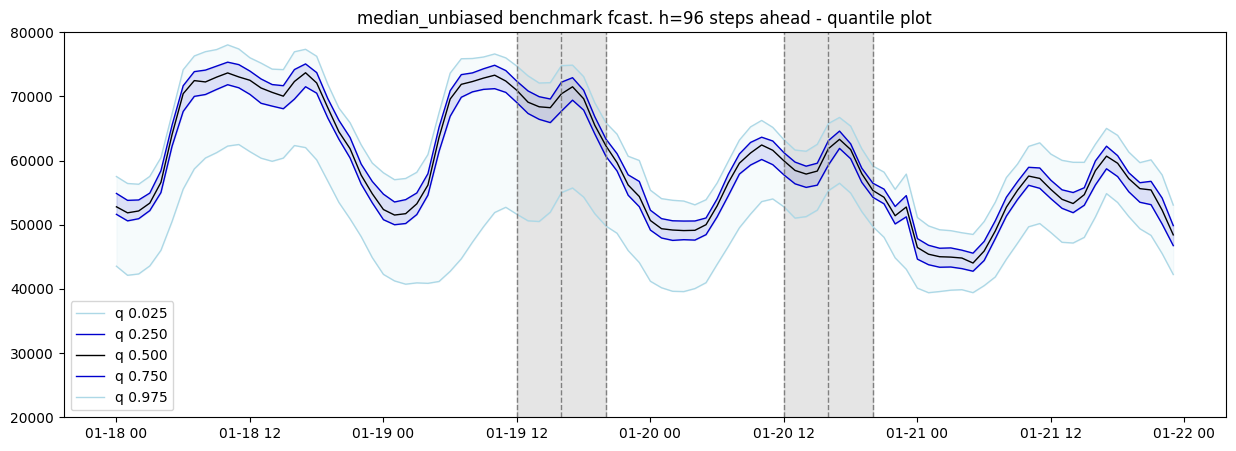

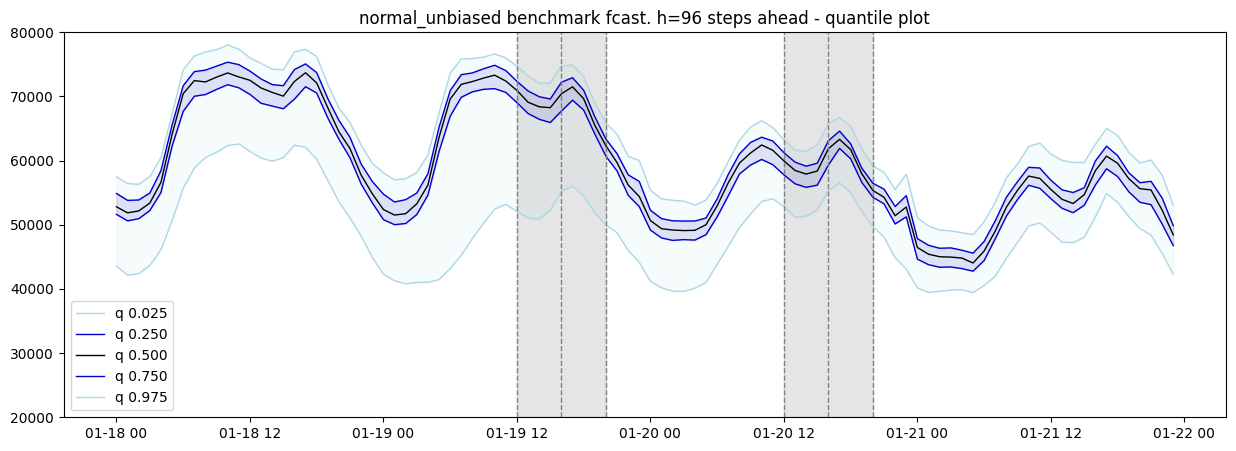

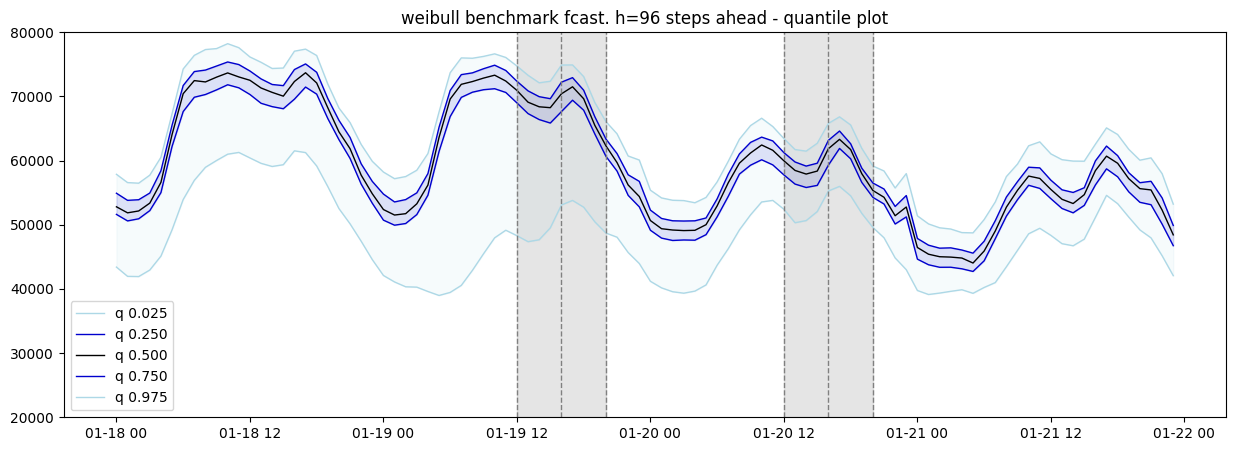

In [16]:
for method in methods:
    model_train.plot_quantile_fcast(dict_benchmark_fcast[method], subm_timestamps, title=f'{method} benchmark fcast. h=96 steps ahead')

In [17]:
# # compare the q 0.975 quantile of all benchmarks
# plt.figure(figsize=(15,5))
# for method in methods:
#     plt.plot(dict_benchmark_fcast[method]['timestamp_CET'], dict_benchmark_fcast[method]['q 0.975'], label=method)
# plt.legend()
# plt.show()

### Direct h-step Grad Boost Fcast using Naive Benchmark

### Combine Ensemble = Direct QR + Direct GB + Benchmark

### Get Actual Data

In [18]:
from importlib import reload
reload(data_prepro)
reload(model_train)

<module 'model_train' from 'C:\\2023_11-PTSFC\\model_train.py'>

In [19]:
""" 
now since we ran the model in retrospect on a past week 
we can compare the fcast with the actual values and compute quantile scores etc

"""

# = = = = = = = = = = = = = 
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = = 
# get data
df_energy_new = data_prepro.get_energy_data_today(to_date=t_wednesday_next.strftime('%Y%m%d'))
df_energy_new.info()
df_energy_new.tail(5)

next thu = 2024-01-24 00:00:00
> cwd = C:\2023_11-PTSFC


> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]


> 0 NA in df
> last valid index = 2024-01-23 17:00:00+00:00
> done and saved to 2015-01-01_2024-01-23_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79435 entries, 2014-12-31 23:00:00+00:00 to 2024-01-23 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79435 non-null  datetime64[ns, CET]
 1   gesamt         79435 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-23 13:00:00+00:00,2024-01-23 14:00:00+01:00,69908.25
2024-01-23 14:00:00+00:00,2024-01-23 15:00:00+01:00,69072.50
2024-01-23 15:00:00+00:00,2024-01-23 16:00:00+01:00,68977.50
2024-01-23 16:00:00+00:00,2024-01-23 17:00:00+01:00,71559.00
2024-01-23 17:00:00+00:00,2024-01-23 18:00:00+01:00,17923.25


### Evaluation

In [20]:
reload(model_train)

<module 'model_train' from 'C:\\2023_11-PTSFC\\model_train.py'>

In [21]:
def eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[20_000, 80_000]):

    """ 
    imported data up to (and including) sunday of the fcast week
    first subset the required data from df_energy_new ...ie t_wednesday to t_sunday
    then plot the iterative fcast from thursday to sunday
    against the actual values in the same plot for comparison

    """
    # plot all actual values inbetween fcast timeframe
    mask = (df_energy_new['timestamp_CET'] >= df_fcast['timestamp_CET'].min()) & (df_energy_new['timestamp_CET'] <= df_fcast['timestamp_CET'].max())
    actual_df = df_energy_new.loc[mask]

    # plot actual values only for the fcast timestamps
    # actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # = = = = = = = = = = = = = 
    # plot

    plt.figure(figsize=(15, 5))
    plt.title(f'quantile fcast evaluation')

    cols = ['temp', 'lightblue', 'mediumblue', 'black', 'mediumblue', 'lightblue']
    for idx, quantile in enumerate(df_fcast.columns):
        if 'timestamp' in quantile:
            continue
        y_pred = df_fcast[quantile]
        # Plot the prediction line
        plt.plot(df_fcast['timestamp_CET'], y_pred, label=f'{quantile}', lw=1, alpha=1, color=cols[idx])

    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.025'], df_fcast['q 0.975'], color='lightblue', alpha=0.1)
    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.250'], df_fcast['q 0.750'], color='mediumblue', alpha=0.1)

    # highlight submission timeframes
    plt.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
    plt.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

    # for timestamp in submission idx, make vertical line
    for timestamp in subm_timestamps:
        plt.axvline(timestamp, color='grey', linestyle='--', lw=1)

    # plot actual values
    plt.plot(actual_df['timestamp_CET'], actual_df['gesamt'], lw=1, label='actual', color='red')

    plt.ylim(ylims)
    plt.legend()
    plt.show()

    """ 
    to calculate the error, we can only subset the actual values for the fcast timestamps
    because otherwise the actual_df will have more values than the fcast_df
    
    now that everything lines up ... we can compute the quantile scores 
    and other error metrics such as MAE, MAPE, MSE, etc
    do it for the entire iterative fcast and also for the 6 submission fcast timestamps

    """

    actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # for entire iterative fcast
    # ==========================
    print('- '*15)
    print(f"entire iterative fcast")
    print('- '*15)

    mae = mean_absolute_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAE = {mae}")
    mse = mean_squared_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MSE = {mse}")
    mape = mean_absolute_percentage_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAPE = {mape}")

    quantile_scores = []
    for q in quantiles:
        quantile_scores.append(mean_pinball_loss(actual_df['gesamt'], df_fcast[f'q {q:.3f}']))
    print(quantile_scores)

    # for submission fcast timestamps
    # ===============================
    print('- '*15)
    print(f"submission fcast timestamps")
    print('- '*15)

    mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'].isin(subm_timestamps), 'gesamt'].values, 
                              df_fcast.loc[df_fcast['timestamp_CET'].isin(subm_timestamps), 'q 0.500'].values)
    print(f"MAE q 0.5 = {mae}")

    df_error_metrics = pd.DataFrame(index=subm_timestamps)
    for timestamp in subm_timestamps:
        mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, 'q 0.500'].values)
        df_error_metrics.loc[timestamp, 'abs error q 0.5'] = mae

        for q in quantiles:
            quantile_score = mean_pinball_loss(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                               df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, f'q {q:.3f}'].values,
                                               alpha=q) / 1000 * 2
            # save in df
            df_error_metrics.loc[timestamp, f'q-score {q:.3f}'] = quantile_score

    # add last row to df_error_metrics which is the avg of the cols
    df_error_metrics.loc['avg', :] = df_error_metrics.mean(axis=0)
    
    display(df_error_metrics)

#### Evaluate only Submission File

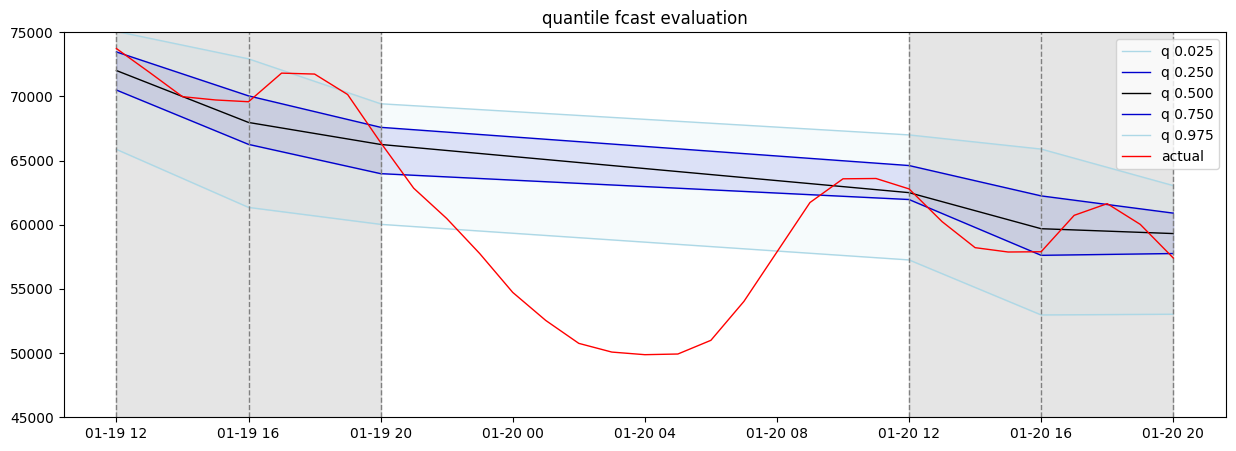

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 1242.962895451389
MSE = 2079160.9189159914
MAPE = 0.01955622017361478
[3108.391577764727, 868.8464955564936, 621.4814477256945, 964.5659393184184, 2129.6421680956396]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1242.962895451389


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,1712.273306,0.392735,1.616026,1.712273,0.390605,0.066897
2024-01-19 16:00:00+01:00,1614.096354,0.411690,1.661109,1.614096,0.228503,0.167147
2024-01-19 20:00:00+01:00,145.696992,0.318533,1.210110,0.145697,0.594905,0.151260
2024-01-20 12:00:00+01:00,290.792300,0.276627,0.413153,0.290792,0.911006,0.210446
2024-01-20 16:00:00+01:00,1793.701624,0.246253,0.139747,1.793702,2.175808,0.400033
2024-01-20 20:00:00+01:00,1901.216796,0.219197,0.518802,1.901217,1.746971,0.282003
avg,1242.962895,0.310839,0.926491,1.242963,1.007967,0.212964


In [26]:
# read in csv file

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

# get csv filename from path that includes Thormund
fnames = [f for f in os.listdir(path) if 'Tormund' in f]
if len(fnames) > 0:
    fname = fnames[0]
else:
    print("no file found")

df_fcast = pd.read_csv(f"{path}/{fname}")
df_fcast = df_fcast[df_fcast.target == 'energy']
df_fcast['timestamp_CET'] = subm_timestamps
# make index = timestamp_CET turned to UTC
df_fcast.index = pd.to_datetime(df_fcast['timestamp_CET']).dt.tz_convert('UTC').rename('timestamp_UTC')
df_fcast = df_fcast[['timestamp_CET', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']]
df_fcast.columns = ['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']
df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] = df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] * 1000

# display(df_fcast)
# display(df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])])

eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[45_000, 75_000])

#### Evaluate Entire Fcast

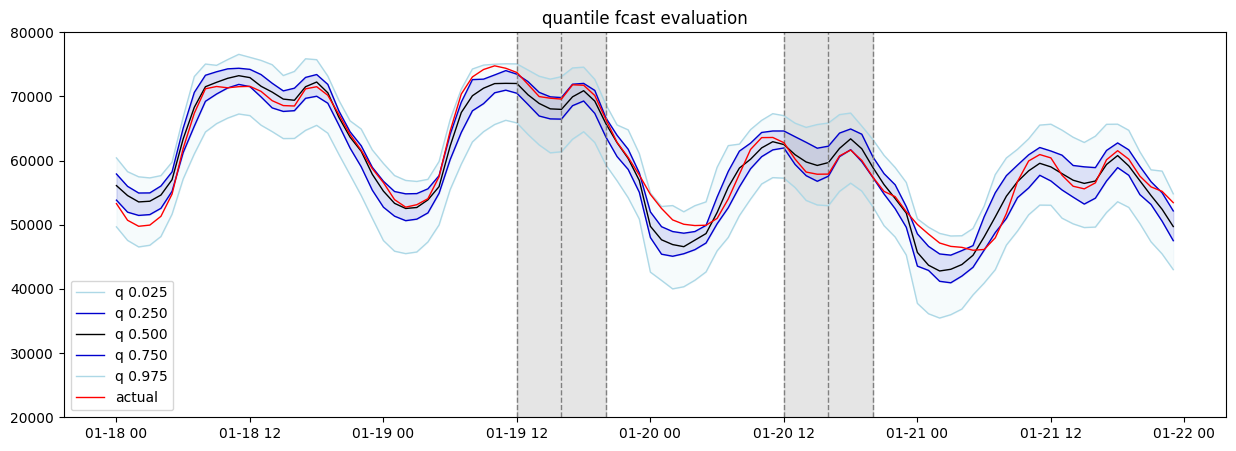

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 1630.8264844540197
MSE = 4176333.614243126
MAPE = 0.028774998756472048
[3496.2923511896793, 1247.6941355491922, 815.4132422270098, 1024.8464066561212, 2059.854979436959]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1262.7522571728998


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,1712.273306,0.392735,1.616026,1.712273,0.390605,0.066897
2024-01-19 16:00:00+01:00,1603.681307,0.410627,1.561244,1.603681,0.119611,0.174908
2024-01-19 20:00:00+01:00,658.911616,0.354057,1.369253,0.658912,0.127411,0.116589
2024-01-20 12:00:00+01:00,290.792300,0.276627,0.413153,0.290792,0.911006,0.210446
2024-01-20 16:00:00+01:00,1793.701624,0.246253,0.163634,1.793702,2.175808,0.398039
2024-01-20 20:00:00+01:00,1517.153390,0.230775,0.025576,1.517153,1.581867,0.293226
avg,1262.752257,0.318512,0.858148,1.262752,0.884385,0.210017


In [23]:
eval_fcast(df_iter_fcast_all_fixed, df_energy_new, subm_timestamps, quantiles)

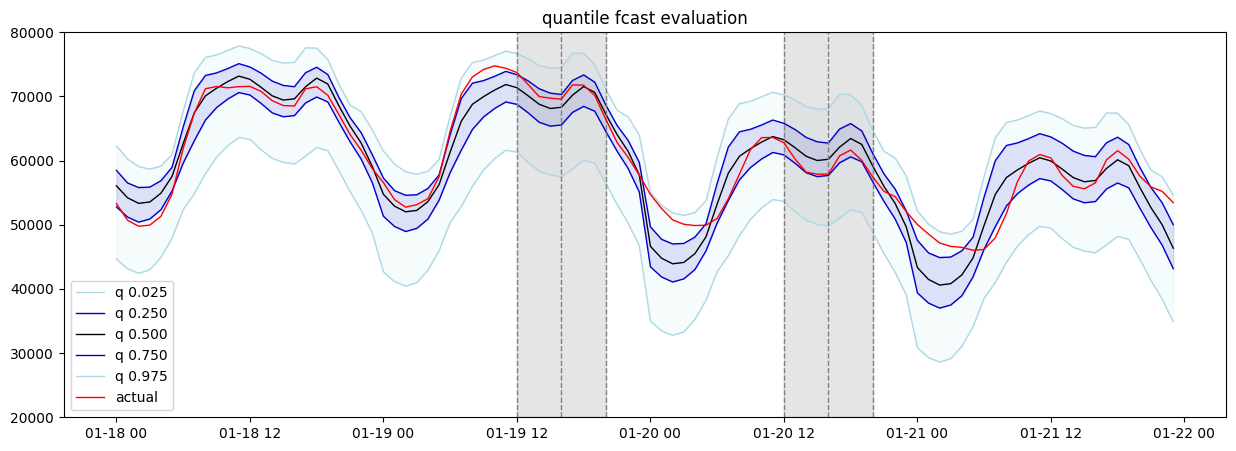

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2290.3567708333335
MSE = 9229786.316080729
MAPE = 0.04116789821352431
[5719.700520833333, 1800.6386718749998, 1145.1783854166667, 1549.5052083333333, 2957.730282738096]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 1485.8541666666667


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,2372.875000,0.620375,2.481635,2.372875,0.508875,0.147271
2024-01-19 16:00:00+01:00,1275.125000,0.605137,2.014875,1.275125,0.363625,0.246202
2024-01-19 20:00:00+01:00,808.250000,0.497713,0.942250,0.808250,1.120875,0.233820
2024-01-20 12:00:00+01:00,457.500000,0.457388,0.948375,0.457500,1.506375,0.373305
2024-01-20 16:00:00+01:00,2307.500000,0.404538,0.105490,2.307500,2.415750,0.509848
2024-01-20 20:00:00+01:00,1693.875000,0.431963,0.381365,1.693875,1.824500,0.362616
avg,1485.854167,0.502852,1.145665,1.485854,1.290000,0.312177


In [24]:
eval_fcast(df_quant_reg_direct_fcast, df_energy_new, subm_timestamps, quantiles)

#### Evaluation of Benchmark

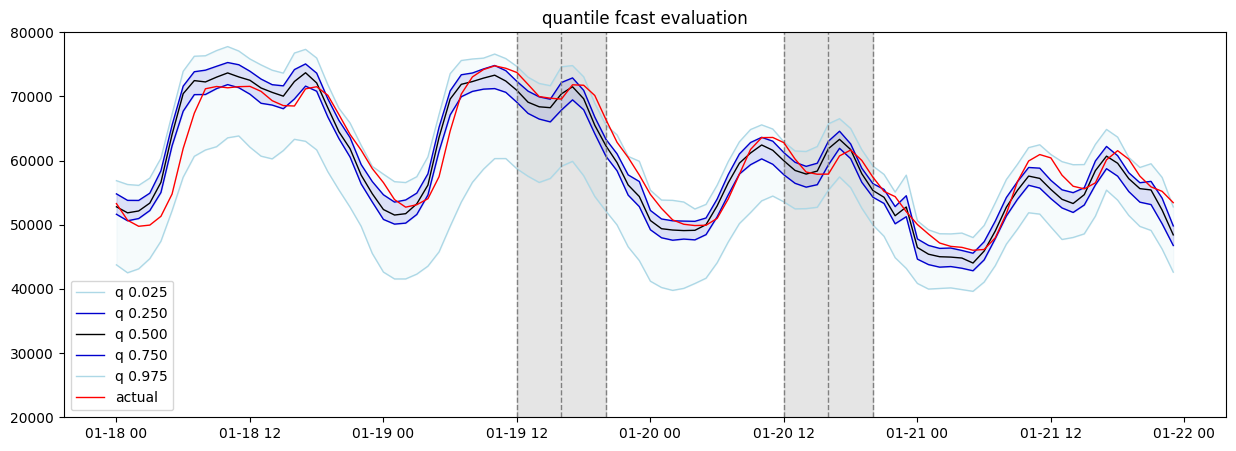

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2317.94921875
MSE = 8162968.626790364
MAPE = 0.039283126630824804
[4683.055501302083, 1480.3997395833333, 1158.974609375, 1103.0322265625, 1757.511393229166]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 2759.6458333333335


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,2788.375000,0.750414,2.324125,2.788375,2.082656,0.047221
2024-01-19 16:00:00+01:00,817.875000,0.523735,0.857000,0.817875,1.291031,0.251632
2024-01-19 20:00:00+01:00,4095.625000,0.713398,2.861875,4.095625,4.622906,1.707554
2024-01-20 12:00:00+01:00,2825.000000,0.461346,2.502750,2.825000,2.334750,0.005760
2024-01-20 16:00:00+01:00,3959.500000,0.125027,2.146500,3.959500,2.560375,0.391184
2024-01-20 20:00:00+01:00,2071.500000,0.372154,1.555063,2.071500,1.497375,0.087057
avg,2759.645833,0.491012,2.041219,2.759646,2.398182,0.415068


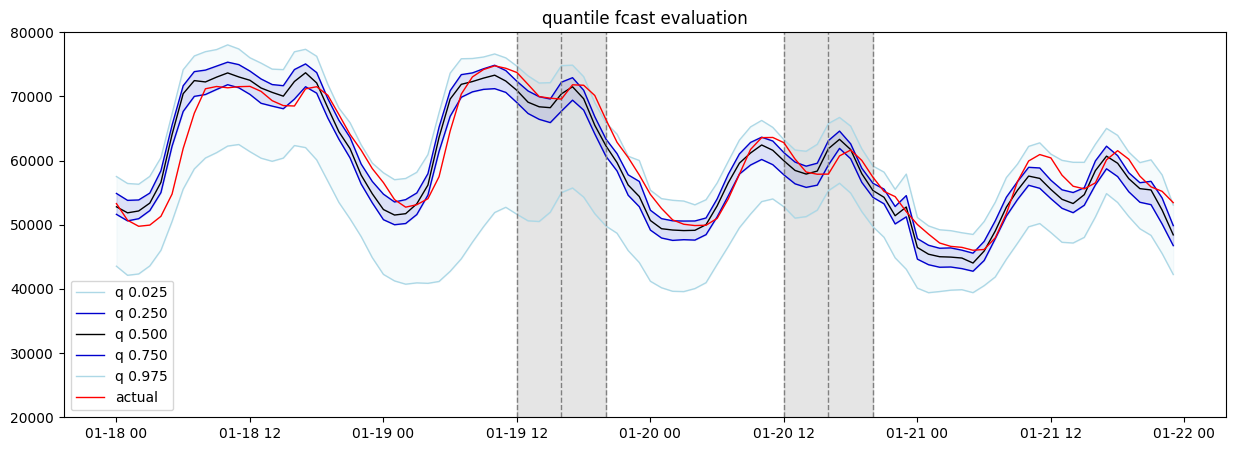

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2317.94921875
MSE = 8162968.626790364
MAPE = 0.039283126630824804
[5530.743305121527, 1495.1303168402776, 1158.974609375, 1104.6830512152776, 1882.151888020832]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 2759.6458333333335


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,2788.375000,1.104780,2.347833,2.788375,2.059125,0.049192
2024-01-19 16:00:00+01:00,817.875000,0.729442,0.938937,0.817875,1.315094,0.260563
2024-01-19 20:00:00+01:00,4095.625000,0.829813,2.863354,4.095625,4.560062,0.981683
2024-01-20 12:00:00+01:00,2825.000000,0.499607,2.508833,2.825000,2.328750,0.023303
2024-01-20 16:00:00+01:00,3959.500000,0.129484,2.116750,3.959500,2.607208,0.393670
2024-01-20 20:00:00+01:00,2071.500000,0.385193,1.566021,2.071500,1.405375,0.087302
avg,2759.645833,0.613053,2.056955,2.759646,2.379269,0.299285


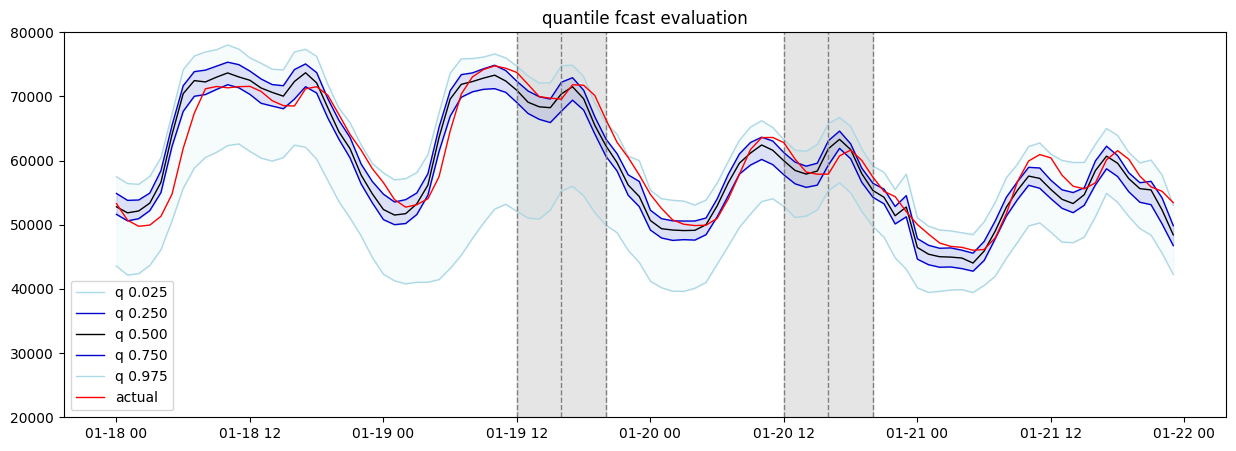

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2317.94921875
MSE = 8162968.626790364
MAPE = 0.039283126630824804
[5477.7628173828125, 1494.0861002604167, 1158.974609375, 1104.5748697916667, 1874.3618570963545]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 2759.6458333333335


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,2788.375000,1.082632,2.345250,2.788375,2.060437,0.049069
2024-01-19 16:00:00+01:00,817.875000,0.716585,0.934391,0.817875,1.315039,0.260004
2024-01-19 20:00:00+01:00,4095.625000,0.822537,2.862984,4.095625,4.560703,1.027050
2024-01-20 12:00:00+01:00,2825.000000,0.497216,2.508453,2.825000,2.329125,0.022207
2024-01-20 16:00:00+01:00,3959.500000,0.129205,2.118609,3.959500,2.604281,0.393514
2024-01-20 20:00:00+01:00,2071.500000,0.384378,1.565336,2.071500,1.411125,0.087287
avg,2759.645833,0.605426,2.055837,2.759646,2.380118,0.306522


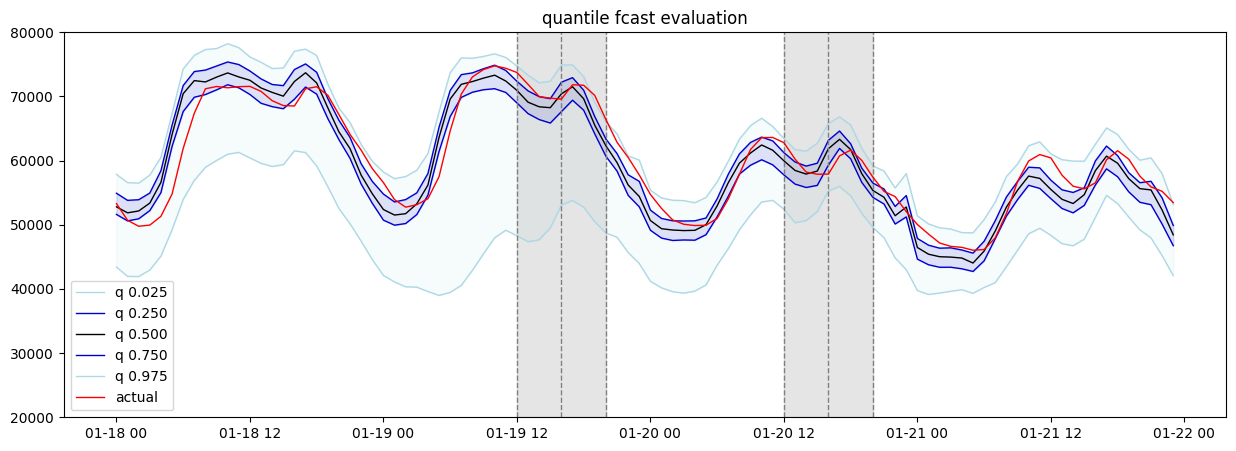

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2317.94921875
MSE = 8162968.626790364
MAPE = 0.039283126630824804
[5980.157845052083, 1503.4840494791667, 1158.974609375, 1105.5485026041667, 1947.4721354166643]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 2759.6458333333335


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-19 12:00:00+01:00,2788.375000,1.271577,2.368500,2.788375,2.048625,0.050472
2024-01-19 16:00:00+01:00,817.875000,0.825343,0.975313,0.817875,1.315531,0.265206
2024-01-19 20:00:00+01:00,4095.625000,0.884655,2.866312,4.095625,4.554938,0.629362
2024-01-20 12:00:00+01:00,2825.000000,0.518738,2.511875,2.825000,2.325750,0.032075
2024-01-20 16:00:00+01:00,3959.500000,0.131713,2.101875,3.959500,2.630625,0.394913
2024-01-20 20:00:00+01:00,2071.500000,0.391713,1.571500,2.071500,1.359375,0.087425
avg,2759.645833,0.670623,2.065896,2.759646,2.372474,0.243242


In [25]:
# iterate over dict dict_benchmark_fcast
for method, df_benchmark in dict_benchmark_fcast.items():
    eval_fcast(df_benchmark, df_energy_new, subm_timestamps, quantiles)